We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

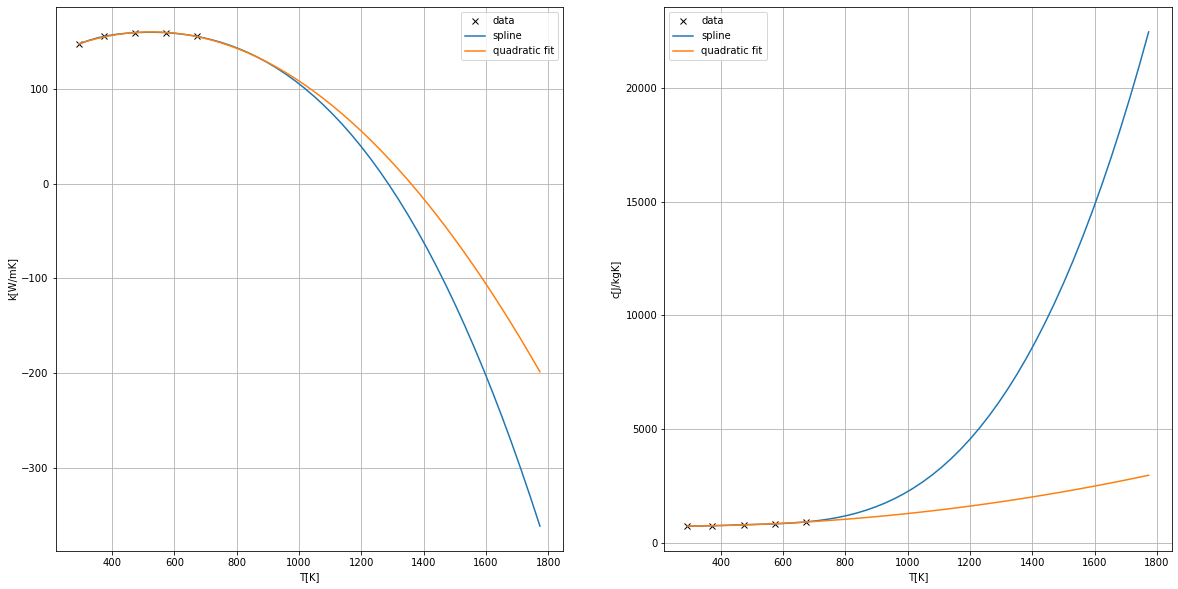

In [3]:
from scipy.optimize import curve_fit

T_range = np.linspace(20, 1500) + 273.15

def func(x, a, b, c):
    return a + b*x + c*x**2

k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

p_k, q_k = curve_fit(func, T, k_s)
p_c, q_c = curve_fit(func, T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx', label = 'data')
ax1.plot(T_range, k_interpolate(T_range), label = 'spline')
ax1.plot(T_range, func(T_range, p_k[0], p_k[1], p_k[2]), label = 'quadratic fit')
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()
ax1.legend()

ax2.plot(T, c, 'kx', label = 'data')
ax2.plot(T_range, c_interpolate(T_range), label = 'spline')
ax2.plot(T_range, func(T_range, p_c[0], p_c[1], p_c[2]), label = 'quadratic fit')
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()
ax2.legend()

Defining the geometry of the powderbed:

In [4]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1.54e-3
y_max = 0.7e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [5]:
t_max = 0.005

time = dde.geometry.TimeDomain(0.0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [6]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

In [7]:
def top_bc(X):
    
    r_sq = (X[:,0] - x_max/4 - X[:,3]*v)**2 + (X[:,1] - y_max/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

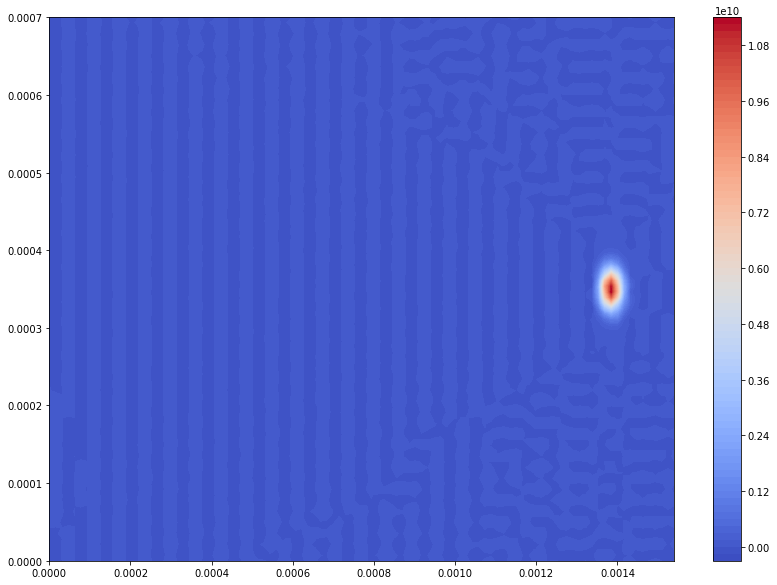

In [8]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [9]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    #k_eff = func(T, p_k[0], p_k[1], p_k[2])
    #c_eff = func(T, p_c[0], p_c[1], p_c[2])
    
    k_eff = 155
    c_eff = 922
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/rho*c_eff
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [10]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/155.0, lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/10))

creating the dataset:

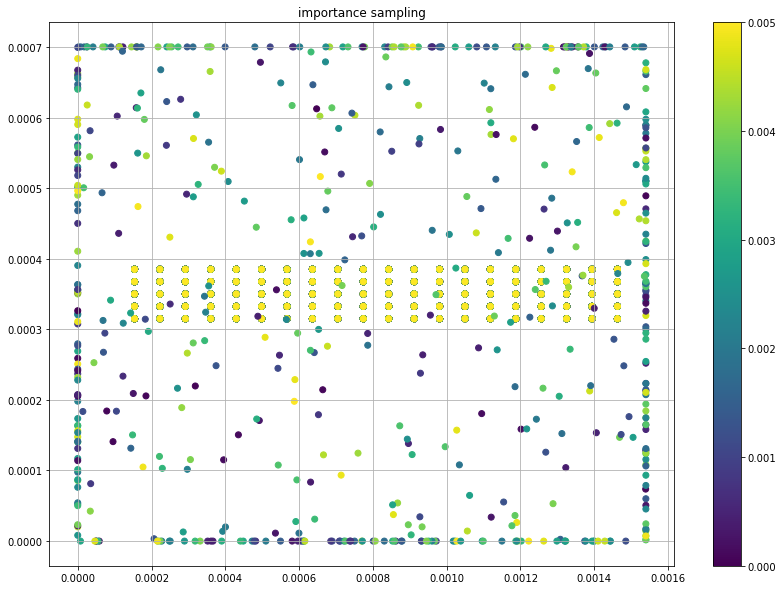

In [11]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.1*x_max, 0.95*x_max, 20)
y_lin = np.linspace(0.45*y_max, 0.55*y_max, 5)
z_lin = np.linspace(0.9*z_max, z_max, 10)
t_lin = np.linspace(0, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_lin], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 500,
                       train_distribution="pseudo",
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (14, 10))
plt.scatter(points[0], points[1], c = points[3])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

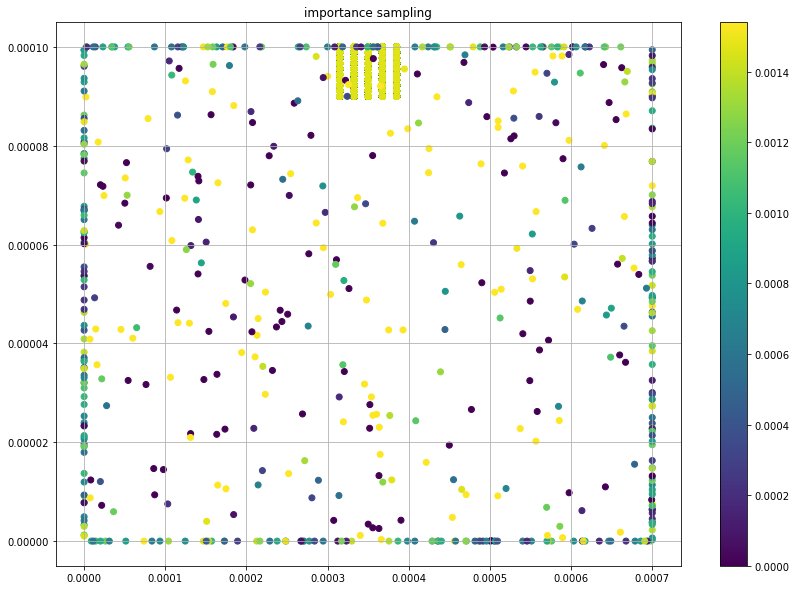

In [12]:
plt.figure(figsize = (14, 10))
plt.scatter(points[1], points[2], c = points[0])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [13]:
#net = dde.nn.FNN([4] + [100] * 4 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [60] * 4 + [1], "sin", "Glorot normal", sigmas = [1e-1, 1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = t*Temperature*1000*1e1 + 20.0 + T_0
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-24 13:05:41.329945: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-24 13:05:41.329971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Katana-GF66): /proc/driver/nvidia/version does not exist
2022-05-24 13:05:41.332142: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI 

'compile' took 1.765285 s



In [14]:
losshistory, train_state = model.train(epochs=0, display_every=1000)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-23 16:40:37.597006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 16:40:37.620805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 16:40:37.621164: I tensorflow/stream_execu

'compile' took 3.192154 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.05e+22, 4.18e+13, 6.01e+02]    [5.05e+22, 4.18e+13, 6.01e+02]    []  

Best model at step 0:
  train loss: 5.05e+22
  test loss: 5.05e+22
  test metric: []

'train' took 1.163678 s



In [15]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 1.759169 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.99e-02, 9.94e-01, 3.35e-01]    [2.99e-02, 9.94e-01, 3.35e-01]    []  
100       [1.30e-03, 9.96e-01, 9.54e-04]    [1.30e-03, 9.96e-01, 9.54e-04]    []  
200       [1.21e-03, 9.94e-01, 8.90e-04]    [1.22e-03, 9.94e-01, 8.90e-04]    []  
300       [1.23e-03, 9.93e-01, 9.30e-04]    [1.08e-03, 9.93e-01, 9.30e-04]    []  
400       [1.51e-03, 9.92e-01, 1.08e-03]    [1.23e-03, 9.92e-01, 1.08e-03]    []  
500       [1.72e-03, 9.90e-01, 1.34e-03]    [1.63e-03, 9.90e-01, 1.34e-03]    []  
600       [2.92e-03, 9.88e-01, 1.54e-03]    [2.95e-03, 9.88e-01, 1.54e-03]    []  
700       [2.08e-03, 9.86e-01, 1.75e-03]    [2.87e-03, 9.86e-01, 1.75e-03]    []  
800       [2.80e-03, 9.85e-01, 1.92e-03]    [2.38e-03, 9.85e-01, 1.92e-03]    []  
900       [2.83e-03, 9.81e-01, 2.03e-03]    [4.26e-03, 9.81e-01, 2.03e-0

In [22]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 3.742745 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [1.01e-02, 9.31e-01, 2.42e-03]    [6.64e-03, 9.31e-01, 2.42e-03]    []  
2100      [6.49e-03, 9.34e-01, 1.78e-03]    [4.83e-03, 9.34e-01, 1.78e-03]    []  
2200      [6.83e-03, 9.27e-01, 1.78e-03]    [6.53e-03, 9.27e-01, 1.78e-03]    []  
2300      [7.48e-03, 9.22e-01, 2.00e-03]    [6.81e-03, 9.22e-01, 2.00e-03]    []  
2400      [8.44e-03, 9.16e-01, 2.15e-03]    [7.09e-03, 9.16e-01, 2.15e-03]    []  
2500      [6.65e-03, 9.07e-01, 1.75e-03]    [9.51e-03, 9.07e-01, 1.75e-03]    []  
2600      [1.37e-01, 8.97e-01, 1.79e-03]    [1.42e-01, 8.97e-01, 1.79e-03]    []  
2700      [9.15e-03, 8.94e-01, 1.64e-03]    [1.24e-02, 8.94e-01, 1.64e-03]    []  
2800      [9.66e-03, 8.88e-01, 1.48e-03]    [1.18e-02, 8.88e-01, 1.48e-03]    []  
2900      [1.07e-02, 8.83e-01, 1.41e-03]    [1.13e-02, 8.83e-01, 1.41e-03]    []  
3000      [1.38

In [28]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 2.013321 s

Training model...

Step      Train loss                        Test loss                         Test metric
4000      [1.79e-02, 8.25e-01, 1.42e-03]    [1.57e-02, 8.25e-01, 1.42e-03]    []  
4100      [1.25e-02, 8.64e-01, 1.44e-03]    [1.45e-02, 8.64e-01, 1.44e-03]    []  
4200      [1.00e-02, 8.40e-01, 1.54e-03]    [1.02e-02, 8.40e-01, 1.54e-03]    []  
4300      [1.62e-02, 8.36e-01, 1.73e-03]    [9.58e-03, 8.36e-01, 1.73e-03]    []  
4400      [1.37e-02, 8.30e-01, 1.59e-03]    [1.05e-02, 8.30e-01, 1.59e-03]    []  
4500      [1.33e-02, 8.23e-01, 1.51e-03]    [1.15e-02, 8.23e-01, 1.51e-03]    []  
4600      [6.34e-02, 8.13e-01, 1.44e-03]    [6.65e-02, 8.13e-01, 1.44e-03]    []  
4700      [1.17e-02, 8.06e-01, 1.40e-03]    [1.70e-02, 8.06e-01, 1.40e-03]    []  
4800      [1.50e-02, 8.01e-01, 1.59e-03]    [1.76e-02, 8.01e-01, 1.59e-03]    []  
4900      [2.49e-02, 7.95e-01, 1.29e-03]    [3.25e-02, 7.95e-01, 1.29e-03]    []  
5000      [1.83

In [36]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-4, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 2.106919 s

Training model...

Step      Train loss                        Test loss                         Test metric
6000      [2.05e-02, 7.65e-01, 1.48e-03]    [1.72e-02, 7.65e-01, 1.48e-03]    []  
6100      [1.69e-02, 7.64e-01, 1.46e-03]    [1.67e-02, 7.64e-01, 1.46e-03]    []  
6200      [1.63e-02, 7.63e-01, 1.63e-03]    [1.64e-02, 7.63e-01, 1.63e-03]    []  
6300      [1.74e-02, 7.62e-01, 1.67e-03]    [1.67e-02, 7.62e-01, 1.67e-03]    []  
6400      [1.97e-02, 7.58e-01, 1.53e-03]    [2.04e-02, 7.58e-01, 1.53e-03]    []  
6500      [1.35e-02, 7.49e-01, 1.50e-03]    [2.10e-02, 7.49e-01, 1.50e-03]    []  
6600      [1.37e-02, 7.42e-01, 1.57e-03]    [2.29e-02, 7.42e-01, 1.57e-03]    []  
6700      [1.98e-02, 7.45e-01, 1.89e-03]    [2.45e-02, 7.45e-01, 1.89e-03]    []  
6800      [1.87e-02, 7.37e-01, 1.64e-03]    [1.99e-02, 7.37e-01, 1.64e-03]    []  
6900      [2.15e-02, 7.32e-01, 1.53e-03]    [2.16e-02, 7.32e-01, 1.53e-03]    []  
7000      [1.37

In [42]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-4, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=1000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 2.094449 s

Training model...

Step      Train loss                        Test loss                         Test metric
8000      [2.22e-02, 6.99e-01, 1.95e-03]    [2.27e-02, 6.99e-01, 1.95e-03]    []  
8100      [1.80e-02, 6.97e-01, 1.87e-03]    [2.23e-02, 6.97e-01, 1.87e-03]    []  
8200      [1.86e-02, 6.93e-01, 1.77e-03]    [2.29e-02, 6.93e-01, 1.77e-03]    []  
8300      [4.41e-02, 7.06e-01, 2.54e-03]    [2.77e-02, 7.06e-01, 2.54e-03]    []  
8400      [2.12e-02, 6.98e-01, 1.81e-03]    [2.22e-02, 6.98e-01, 1.81e-03]    []  
8500      [3.16e-02, 6.99e-01, 1.99e-03]    [2.41e-02, 6.99e-01, 1.99e-03]    []  
8600      [2.17e-02, 6.94e-01, 1.87e-03]    [2.56e-02, 6.94e-01, 1.87e-03]    []  
8700      [2.20e-02, 6.90e-01, 2.11e-03]    [2.58e-02, 6.90e-01, 2.11e-03]    []  
8800      [1.94e-02, 6.85e-01, 1.78e-03]    [2.74e-02, 6.85e-01, 1.78e-03]    []  
8900      [2.66e-02, 6.83e-01, 1.80e-03]    [2.76e-02, 6.83e-01, 1.80e-03]    []  
9000      [3.49

In [43]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-5, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=10000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 3.167582 s

Training model...

Step      Train loss                        Test loss                         Test metric
9000      [4.46e-02, 6.94e-01, 1.99e-03]    [2.55e-02, 6.94e-01, 1.99e-03]    []  
9100      [3.36e-02, 6.92e-01, 1.97e-03]    [2.30e-02, 6.92e-01, 1.97e-03]    []  
9200      [2.24e-02, 6.89e-01, 1.91e-03]    [2.10e-02, 6.89e-01, 1.91e-03]    []  
9300      [2.29e-02, 6.86e-01, 1.80e-03]    [2.24e-02, 6.86e-01, 1.80e-03]    []  
9400      [1.92e-02, 6.83e-01, 1.87e-03]    [2.34e-02, 6.83e-01, 1.87e-03]    []  
9500      [2.10e-02, 6.81e-01, 1.78e-03]    [2.32e-02, 6.81e-01, 1.78e-03]    []  
9600      [2.07e-02, 6.78e-01, 1.80e-03]    [2.39e-02, 6.78e-01, 1.80e-03]    []  
9700      [3.13e-02, 6.82e-01, 1.95e-03]    [2.33e-02, 6.82e-01, 1.95e-03]    []  
9800      [2.75e-02, 6.79e-01, 1.78e-03]    [2.38e-02, 6.79e-01, 1.78e-03]    []  
9900      [2.99e-02, 6.80e-01, 1.88e-03]    [2.34e-02, 6.80e-01, 1.88e-03]    []  
10000     [3.35

18700     [1.80e-02, 6.09e-01, 1.67e-03]    [2.77e-02, 6.09e-01, 1.67e-03]    []  
18800     [2.02e-02, 6.07e-01, 1.67e-03]    [2.77e-02, 6.07e-01, 1.67e-03]    []  
18900     [2.38e-02, 6.04e-01, 1.80e-03]    [3.02e-02, 6.04e-01, 1.80e-03]    []  
19000     [2.43e-02, 6.03e-01, 1.73e-03]    [2.91e-02, 6.03e-01, 1.73e-03]    []  

Best model at step 18800:
  train loss: 6.29e-01
  test loss: 6.36e-01
  test metric: []

'train' took 4150.821608 s



In [44]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1])
model.compile("adam", lr=1e-5, loss_weights=weights)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=10000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 4.523624 s

Training model...

Step      Train loss                        Test loss                         Test metric
19000     [2.47e-02, 6.03e-01, 1.73e-03]    [2.91e-02, 6.03e-01, 1.73e-03]    []  
19100     [2.30e-02, 6.02e-01, 1.73e-03]    [2.93e-02, 6.02e-01, 1.73e-03]    []  
19200     [2.86e-02, 6.03e-01, 1.72e-03]    [2.90e-02, 6.03e-01, 1.72e-03]    []  
19300     [2.36e-02, 6.02e-01, 1.90e-03]    [3.05e-02, 6.02e-01, 1.90e-03]    []  
19400     [2.31e-02, 6.01e-01, 1.81e-03]    [2.97e-02, 6.01e-01, 1.81e-03]    []  
19500     [2.25e-02, 6.00e-01, 1.72e-03]    [3.18e-02, 6.00e-01, 1.72e-03]    []  
19600     [2.29e-02, 5.99e-01, 1.72e-03]    [3.21e-02, 5.99e-01, 1.72e-03]    []  
19700     [2.31e-02, 6.01e-01, 2.06e-03]    [3.10e-02, 6.01e-01, 2.06e-03]    []  
19800     [2.25e-02, 5.99e-01, 1.84e-03]    [3.17e-02, 5.99e-01, 1.84e-03]    []  
19900     [2.83e-02, 6.03e-01, 1.85e-03]    [3.08e-02, 6.03e-01, 1.85e-03]    []  
20000     [2.03

28700     [2.32e-02, 5.57e-01, 1.74e-03]    [3.19e-02, 5.57e-01, 1.74e-03]    []  
28800     [2.88e-02, 5.61e-01, 1.84e-03]    [3.13e-02, 5.61e-01, 1.84e-03]    []  
28900     [2.05e-02, 5.58e-01, 1.63e-03]    [3.08e-02, 5.58e-01, 1.63e-03]    []  
29000     [3.08e-02, 5.61e-01, 1.69e-03]    [2.87e-02, 5.61e-01, 1.69e-03]    []  

Best model at step 28900:
  train loss: 5.81e-01
  test loss: 5.91e-01
  test metric: []

'train' took 3743.266524 s



In [50]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.194210 s

Training model...

Step      Train loss                        Test loss                         Test metric
29000     [3.59e-02, 5.61e-01, 1.69e-03]    [2.87e-02, 5.61e-01, 1.69e-03]    []  
29100     [2.69e-02, 5.41e-01, 2.68e-03]                                          
29200     [3.27e-02, 5.06e-01, 3.90e-03]                                          
29300     [3.28e-02, 4.81e-01, 4.41e-03]                                          
29400     [3.29e-02, 4.58e-01, 4.75e-03]                                          
29500     [3.51e-02, 4.38e-01, 4.97e-03]                                          
29600     [3.54e-02, 4.21e-01, 5.29e-03]                                          
29700     [3.45e-02, 4.05e-01, 4.56e-03]                                          
29800     [3.46e-02, 3.89e-01, 3.89e-03]                                          
29900     [3.54e-02, 3.73e-01, 4.66e-03]                                          
30000     [3.47

In [66]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.744152 s

Training model...

Step      Train loss                        Test loss                         Test metric
32154     [1.97e-02, 1.51e-01, 2.16e-03]    [2.13e+00, 1.51e-01, 2.16e-03]    []  
32200     [1.92e-02, 1.51e-01, 2.01e-03]                                          
32300     [1.71e-02, 1.51e-01, 1.70e-03]                                          
32400     [1.59e-02, 1.50e-01, 1.54e-03]                                          
32500     [1.51e-02, 1.49e-01, 1.36e-03]                                          
32600     [1.47e-02, 1.47e-01, 1.29e-03]                                          
32700     [1.43e-02, 1.46e-01, 1.27e-03]                                          
32800     [1.41e-02, 1.45e-01, 1.21e-03]                                          
32900     [1.38e-02, 1.43e-01, 1.15e-03]                                          
33000     [1.37e-02, 1.42e-01, 1.17e-03]                                          
33100     [1.37

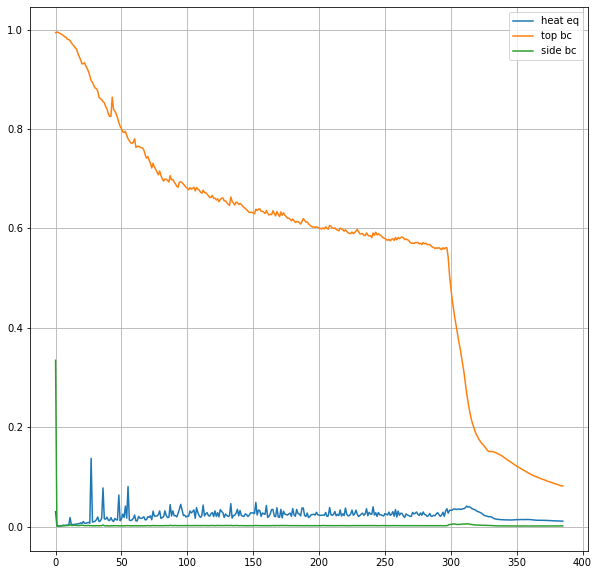

In [67]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 1
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

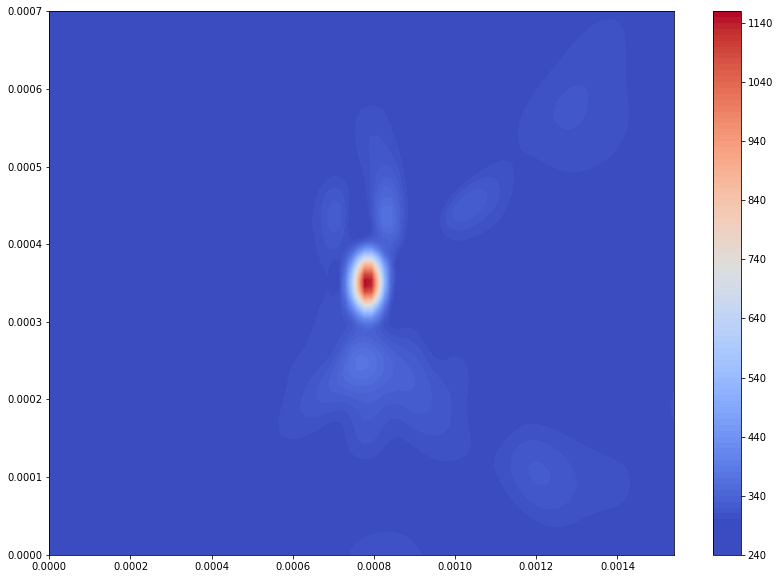

In [52]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0.4*t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

<IPython.core.display.Javascript object>


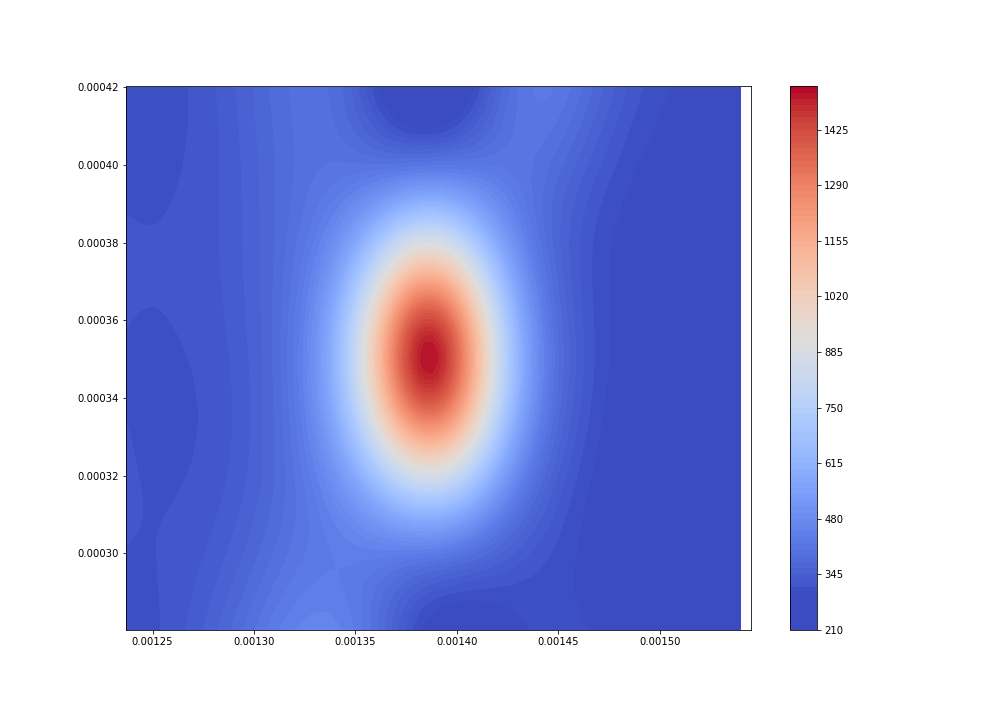

In [39]:
%matplotlib notebook

x_lin = np.linspace(0.8*x_max, x_max)
y_lin = np.linspace(0.4*y_max, 0.6*y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

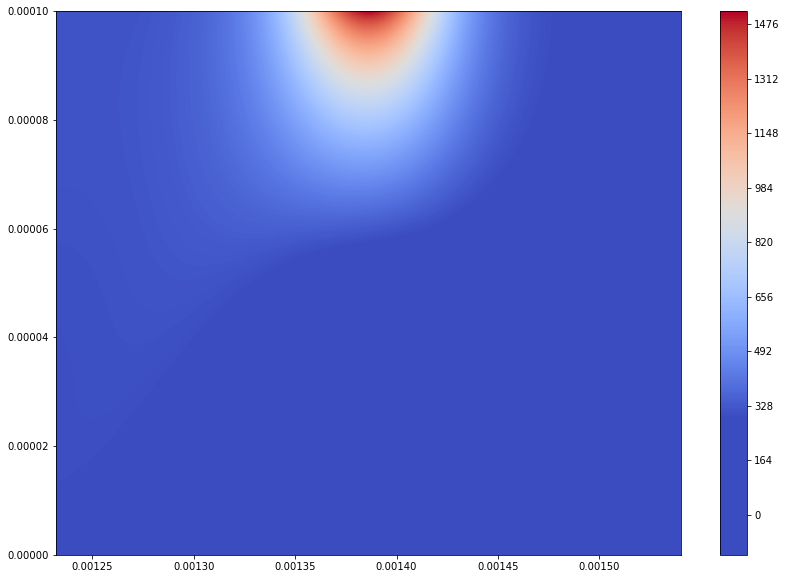

In [16]:
x_lin = np.linspace(0.8*x_max, x_max)
z_lin = np.linspace(0, z_max)
xx, yy, zz, tt = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 1000, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

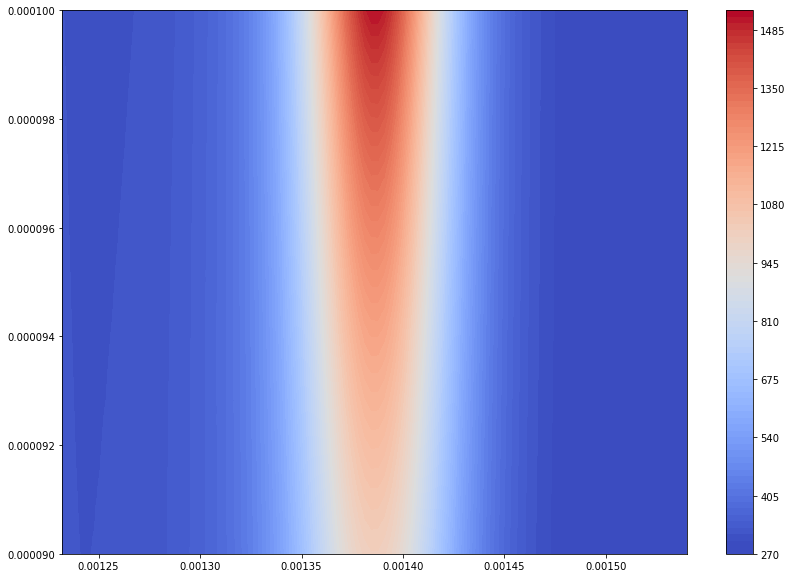

In [71]:
x_lin = np.linspace(0.8*x_max, x_max)
z_lin = np.linspace(0.9*z_max, z_max)
xx, yy, zz, tt = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [23]:
weights = 1/np.array([5.05e+22, 4.18e+13, 6.01e+02])
weights_2 = [1, 1, 1e1]
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 1.594314 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.95e-01, 9.85e-01, 1.10e+01]    [9.95e-01, 9.85e-01, 1.10e+01]    []  
100       [1.23e-03, 9.80e-01, 8.09e-04]                                          
200       [3.35e-03, 9.75e-01, 9.96e-04]                                          
300       [5.97e-03, 9.63e-01, 1.94e-03]                                          
400       [7.78e-03, 9.51e-01, 2.50e-03]                                          
500       [8.18e-03, 9.40e-01, 2.37e-03]                                          
600       [9.92e-03, 9.28e-01, 2.59e-03]                                          
700       [1.44e-02, 9.06e-01, 3.34e-03]                                          
800       [1.66e-02, 8.80e-01, 4.42e-03]                                          
900       [2.10e-02, 8.47e-01, 4.32e-03]                                

In [32]:
weights = 1/np.array([5.05e+22, 4.18e+13, 6.01e+02])
weights_2 = [1, 1, 1e3]
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 1.649149 s

Training model...

Step      Train loss                        Test loss                         Test metric
5335      [2.51e-02, 1.80e-01, 1.98e-01]    [2.51e-02, 1.80e-01, 1.98e-01]    []  
5400      [3.62e-02, 1.80e-01, 7.73e-02]                                          
5500      [3.83e-02, 1.80e-01, 3.15e-02]                                          
5600      [3.60e-02, 1.80e-01, 1.63e-02]                                          
5700      [3.26e-02, 1.80e-01, 1.08e-02]                                          
5800      [3.01e-02, 1.81e-01, 6.97e-03]                                          
5900      [2.85e-02, 1.81e-01, 5.19e-03]                                          
6000      [2.69e-02, 1.81e-01, 3.92e-03]                                          
6100      [2.57e-02, 1.80e-01, 3.02e-03]                                          
6200      [2.44e-02, 1.80e-01, 2.39e-03]                                          
6300      [2.34

In [35]:
weights = 1/np.array([5.05e+22, 4.18e+13, 6.01e+02])
weights_2 = [1, 1, 1e7]
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 1.625641 s

Training model...

Step      Train loss                        Test loss                         Test metric
10769     [1.70e-02, 1.49e-01, 6.07e+00]    [1.70e-02, 1.49e-01, 6.07e+00]    []  
10800     [1.75e-02, 1.50e-01, 5.35e+00]                                          
10900     [2.85e-02, 1.49e-01, 3.58e+00]                                          
11000     [4.15e-02, 1.49e-01, 2.50e+00]                                          
11100     [5.06e-02, 1.49e-01, 2.00e+00]                                          
11200     [5.48e-02, 1.49e-01, 1.68e+00]                                          
11300     [6.73e-02, 1.49e-01, 1.37e+00]                                          
11400     [6.69e-02, 1.49e-01, 1.19e+00]                                          
11500     [5.91e-02, 1.49e-01, 1.04e+00]                                          
11600     [5.91e-02, 1.49e-01, 9.23e-01]                                          
11700     [6.05

In [39]:
weights = 1/np.array([5.05e+22, 4.18e+13, 6.01e+02])
weights_2 = [1, 1, 1e7]
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 1.880414 s

Training model...

Step      Train loss                        Test loss                         Test metric
16265     [3.48e-02, 1.49e-01, 5.93e-02]    [3.48e-02, 1.49e-01, 5.93e-02]    []  
16300     [3.48e-02, 1.49e-01, 5.90e-02]                                          
16400     [3.43e-02, 1.49e-01, 5.73e-02]                                          
16500     [3.38e-02, 1.49e-01, 5.60e-02]                                          
16600     [3.34e-02, 1.49e-01, 5.45e-02]                                          
16700     [3.32e-02, 1.49e-01, 5.26e-02]                                          
16800     [3.28e-02, 1.49e-01, 5.09e-02]                                          
16900     [3.24e-02, 1.49e-01, 4.92e-02]                                          
17000     [3.20e-02, 1.49e-01, 4.78e-02]                                          
17100     [3.17e-02, 1.49e-01, 4.67e-02]                                          
17200     [3.13

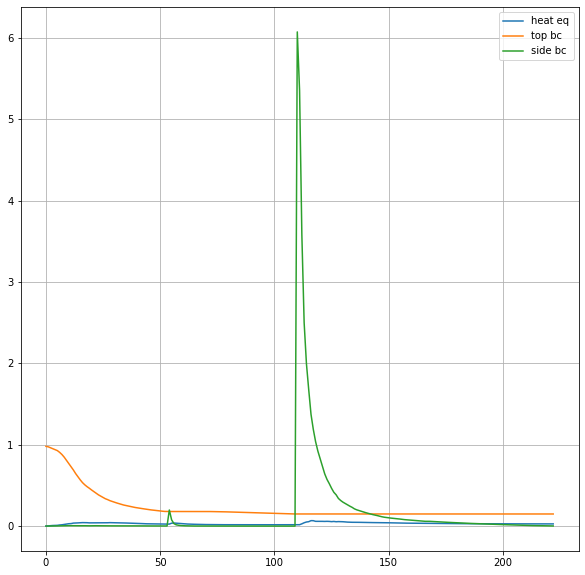

In [40]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 1
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

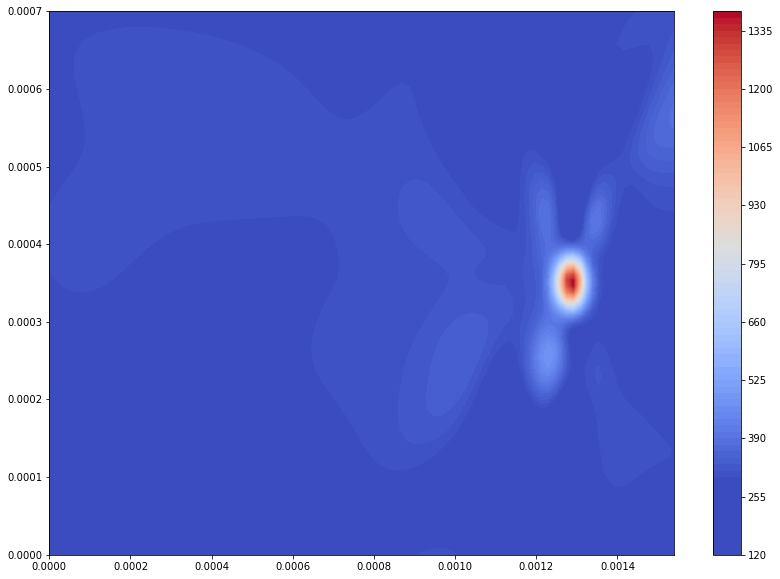

In [16]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0.9*t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

<IPython.core.display.Javascript object>


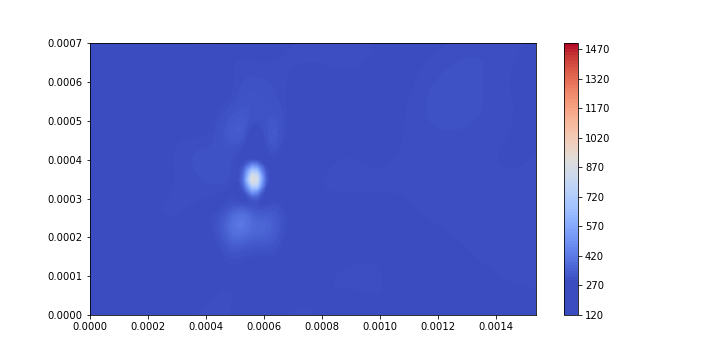

In [40]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1) = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 5))
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
plt.colorbar(CS, ax = ax1)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

In [31]:
data.min()

129.2934877279018

In [14]:
model.save('better/')

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[node save/SaveV2
 (defined at /home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/model.py:127)
]]

Errors may have originated from an input operation.
Input Source operations connected to node save/SaveV2:
In[0] save/Const:	
In[1] save/SaveV2/tensor_names:	
In[2] save/SaveV2/shape_and_slices:	
In[3] Variable (defined at /home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/msffn.py:72)	
In[4] Variable_1:	
In[5] dense/bias (defined at /home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/engine/base_layer_v1.py:423)	
In[6] dense/kernel:	
In[7] fully_connected/dense/bias:	
In[8] fully_connected/dense/kernel:	
In[9] fully_connected/dense_1/bias:	
In[10] fully_connected/dense_1/kernel:	
In[11] fully_connected/dense_2/bias:	
In[12] fully_connected/dense_2/kernel:

Operation defined at: (most recent call last)
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 462, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_4059/2926973350.py", line 21, in <cell line: 21>
>>>     model.compile("adam", lr=1e-5)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/utils/internal.py", line 22, in wrapper
>>>     result = f(*args, **kwargs)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/model.py", line 108, in compile
>>>     self._compile_tensorflow_compat_v1(lr, loss_fn, decay, loss_weights)
>>> 
>>>   File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/model.py", line 127, in _compile_tensorflow_compat_v1
>>>     self.saver = tf.train.Saver(max_to_keep=None)
>>> 

Original stack trace for 'save/SaveV2':
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
    await self.process_one()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 462, in process_one
    await dispatch(*args)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
    await result
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
    reply_content = await reply_content
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    result = self._run_cell(
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
    return runner(coro)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4059/2926973350.py", line 21, in <cell line: 21>
    model.compile("adam", lr=1e-5)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/utils/internal.py", line 22, in wrapper
    result = f(*args, **kwargs)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/model.py", line 108, in compile
    self._compile_tensorflow_compat_v1(lr, loss_fn, decay, loss_weights)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/model.py", line 127, in _compile_tensorflow_compat_v1
    self.saver = tf.train.Saver(max_to_keep=None)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 923, in __init__
    self.build()
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 935, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 963, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 531, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 223, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/training/saver.py", line 138, in save_op
    return io_ops.save_v2(filename_tensor, tensor_names, tensor_slices,
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1713, in save_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3697, in _create_op_internal
    ret = Operation(
  File "/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2101, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [15]:
model.restore('better/-37527.ckpt')

INFO:tensorflow:Restoring parameters from better/-37527.ckpt


In [19]:
ref_data = data = np.genfromtxt('of_data/end_data.csv', delimiter = ',',skip_header = True)

In [20]:
ref_data.shape

(1030301, 5)

In [21]:
X = ref_data[:,0:3].T
t_value = np.ones(len(X[0]))*t_max
X = np.vstack((X, t_value)).T

In [22]:
Y = model.predict(X)

2022-05-24 13:22:51.220859: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 494544480 exceeds 10% of free system memory.
2022-05-24 13:22:51.228357: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 494544480 exceeds 10% of free system memory.
2022-05-24 13:22:51.367683: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 494544480 exceeds 10% of free system memory.
2022-05-24 13:22:51.382668: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 494544480 exceeds 10% of free system memory.
2022-05-24 13:22:51.871063: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 494544480 exceeds 10% of free system memory.


In [23]:
Y.max()

1517.0763077744127

In [24]:
diff = np.abs(Y.T[0] - ref_data[:,3:4].T)

In [25]:
diff.mean()

16.913415644405273

In [27]:
np.sqrt(diff.var())

35.063237249319705

In [28]:
diff.max()

419.69353050840664

In [29]:
diff.min()

6.019191118866729e-06

In [ ]:
plt.hist(diff)